In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, get_bounding_box_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,transform_box_from_world_to_sendor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion
from lyft_dataset_sdk.utils.geometry_utils import points_in_box

In [3]:
from provider import FrustumDataset

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [4]:
lyft_data_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/artifact/lyft_val.pickle"
kitti_data_file="/Users/kanhua/Downloads/frustum-pointnets/kitti/frustum_carpedcyc_val.pickle"
NUM_POINT=1024

In [5]:
dataset=FrustumDataset(npoints=NUM_POINT,split='val',
                       from_rgb_detection=False,
                    overwritten_data_path=lyft_data_file,one_hot=True,rotate_to_center=True)

In [6]:
dataset[1]

(array([[-0.6593089 ,  0.813033  , 26.30311   ,  0.2       ],
        [-0.5393585 ,  1.0389651 , 18.75156   ,  0.2       ],
        [ 1.5777895 ,  1.4150794 , 62.910587  ,  0.2       ],
        ...,
        [ 0.81276554,  2.1659775 , 25.703836  ,  0.2       ],
        [-0.37106884,  1.1099921 , 27.652906  ,  0.2       ],
        [ 0.34463942,  1.8718051 , 25.856762  ,  0.2       ]],
       dtype=float32),
 array([ True, False, False, ..., False,  True,  True]),
 array([ 0.0817595 ,  1.35748782, 27.71142014]),
 4,
 0.10554136527802838,
 0,
 array([0.0198836 , 0.1694326 , 0.19636809]),
 -0.13009332397769513,
 array([1., 0., 0.]))

In [7]:
a=dataset[1]

In [8]:
len(a)

9

In [9]:
type(dataset.input_list)

list

In [10]:
pointset=a[0]
seg=a[1]
box3d_center=a[2]
rot_angle=a[7]

In [11]:
box3d_center

array([ 0.0817595 ,  1.35748782, 27.71142014])

In [12]:
rot_angle

-0.13009332397769513

In [13]:
def rad2deg(radius):
    return radius*180/np.pi

In [14]:
rad2deg(rot_angle)

-7.453798406750006

In [15]:
seg=seg.astype(bool)

In [16]:
pointset_before_transformation=dataset.input_list[1]

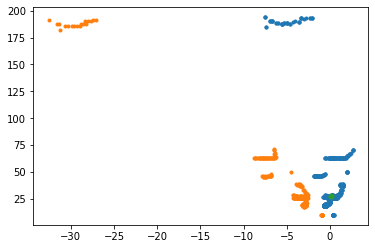

In [17]:
plt.plot(pointset[:,0],pointset[:,2],'.')
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
#plt.plot(pointset[seg,0],pointset[seg,2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)

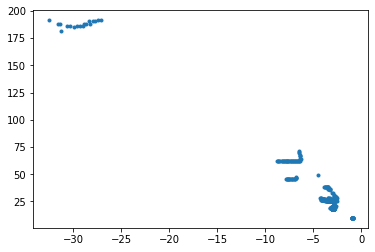

In [18]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')

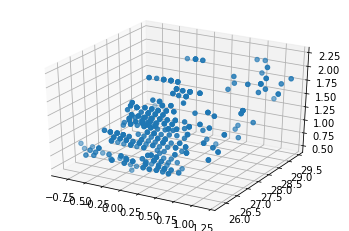

In [19]:
sel_pointset=pointset[seg,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(sel_pointset[:,0],sel_pointset[:,2],sel_pointset[:,1])

## See inference results

In [20]:
import tensorflow as tf
import importlib
from train_util import get_batch
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
# Set training configurations
BATCH_SIZE = 32
MODEL_PATH = "/Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt"
GPU_INDEX = 0
MODEL = importlib.import_module("frustum_pointnets_v1")
NUM_CLASSES = 2
NUM_CHANNEL = 4

In [21]:
# functions excerpted from frustum-pointnet test.py
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:' + str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape) - 1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape) - 1, keepdims=True)
    return probs


def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0] % batch_size == 0
    num_batches = int(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        feed_dict = { \
            ops['pointclouds_pl']: pc[i * batch_size:(i + 1) * batch_size, ...],
            ops['one_hot_vec_pl']: one_hot_vec[i * batch_size:(i + 1) * batch_size, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[i * batch_size:(i + 1) * batch_size, ...] = batch_logits
        centers[i * batch_size:(i + 1) * batch_size, ...] = batch_centers
        heading_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_scores
        heading_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_residuals
        size_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_size_scores
        size_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:, :, 1]  # BxN
        batch_seg_mask = np.argmax(batch_logits, 2)  # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1)  # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,
        heading_prob = np.max(softmax(batch_heading_scores), 1)  # B
        size_prob = np.max(softmax(batch_size_scores), 1)  # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i * batch_size:(i + 1) * batch_size] = batch_scores
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [22]:
sess, ops = get_session_and_ops(batch_size=BATCH_SIZE, num_point=NUM_POINT)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
INFO:tensorflow:Summar

In [23]:
result_dir=None
TEST_DATASET=dataset

## Proecedures of test()
ps_list = []
seg_list = []
segp_list = []
center_list = []
heading_cls_list = []
heading_res_list = []
size_cls_list = []
size_res_list = []
rot_angle_list = []
score_list = []

test_idxs = np.arange(0, len(TEST_DATASET))
batch_size = BATCH_SIZE
num_batches = int(len(TEST_DATASET) / batch_size)
assert ((len(TEST_DATASET) % int(batch_size)) == 0)

sess, ops = get_session_and_ops(batch_size=batch_size, num_point=NUM_POINT)
correct_cnt = 0
for batch_idx in range(num_batches):
    #print('batch idx: %d' % (batch_idx))
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_data, batch_label, batch_center, \
    batch_hclass, batch_hres, batch_sclass, batch_sres, \
    batch_rot_angle, batch_one_hot_vec = \
        get_batch(TEST_DATASET, test_idxs, start_idx, end_idx,
                  NUM_POINT, NUM_CHANNEL)

    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
        inference(sess, ops, batch_data,
                  batch_one_hot_vec, batch_size=batch_size)

    correct_cnt += np.sum(batch_output == batch_label)

    for i in range(batch_output.shape[0]):
        ps_list.append(batch_data[i, ...])
        seg_list.append(batch_label[i, ...])
        segp_list.append(batch_output[i, ...])
        center_list.append(batch_center_pred[i, :])
        heading_cls_list.append(batch_hclass_pred[i])
        heading_res_list.append(batch_hres_pred[i])
        size_cls_list.append(batch_sclass_pred[i])
        size_res_list.append(batch_sres_pred[i, :])
        rot_angle_list.append(batch_rot_angle[i])
        score_list.append(batch_scores[i])

print("Segmentation accuracy: %f" % \
      (correct_cnt / float(batch_size * num_batches * NUM_POINT)))

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from /Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt


/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


Segmentation accuracy: 0.842567


In [24]:
len(TEST_DATASET)

1024

In [25]:
score_list[0]

-0.33324623787255114

In [26]:
segp_list[0]

array([1, 1, 0, ..., 0, 1, 0])

In [27]:
seg_list[0]

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

In [80]:
data_idx=15
np.sum(seg_list[data_idx]==segp_list[data_idx])/seg_list[data_idx].shape

array([0.87890625])

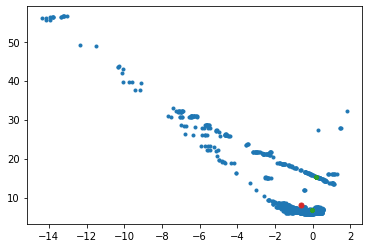

In [81]:
pointset=ps_list[data_idx]
box3d_center=dataset[data_idx][2]
plt.plot(pointset[:,0],pointset[:,2],'.')
#plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(pointset[segp_list[data_idx],0],pointset[segp_list[data_idx],2],'.')
plt.plot(pointset[seg_list[data_idx],0],pointset[seg_list[data_idx],2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
#plt.ylim([4,6])
#plt.xlim([-1,1])

In [82]:
## compare center

In [83]:
center_list[data_idx]

array([-0.61843228,  0.81252939,  7.72187614])

In [84]:
dataset[data_idx][2]

array([-0.59694004,  0.88249572,  7.95628193])

## compare heading

In [85]:
heading_cls_list[data_idx]

8

In [86]:
heading_res_list[data_idx]

0.058928150683641434

### predicted ehading angle

In [87]:
NUM_HEADING_BIN=12
from provider import class2angle
class2angle(heading_cls_list[data_idx],heading_res_list[data_idx],NUM_HEADING_BIN)

-2.0354669517095543

In [88]:
dataset[data_idx][3]

3

### heading angle ground truth:

In [89]:
dataset.heading_list[data_idx]

2.0491216219551713

(array([ 19.,  10.,   1.,   0.,   1.,   3.,   0.,  17., 141.,   1.,   0.,
          3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  23.,   8.,   1.,  17., 714.,  16.,   2.,
          0.,   1.,   3.,  19.,  11.,  13.]),
 array([-3.13651537e+00, -3.01103537e+00, -2.88555538e+00, -2.76007538e+00,
        -2.63459539e+00, -2.50911539e+00, -2.38363540e+00, -2.25815540e+00,
        -2.13267541e+00, -2.00719541e+00, -1.88171542e+00, -1.75623542e+00,
        -1.63075543e+00, -1.50527543e+00, -1.37979544e+00, -1.25431544e+00,
        -1.12883545e+00, -1.00335545e+00, -8.77875458e-01, -7.52395463e-01,
        -6.26915468e-01, -5.01435473e-01, -3.75955478e-01, -2.50475483e-01,
        -1.24995488e-01,  4.84507022e-04,  1.25964502e-01,  2.51444497e-01,
         3.76924492e-01,  5.02404487e-01,  6.27884482e-01,  7.53364477e-01,
         8.78844472e-01,  1.00432447e+00,  1.12980

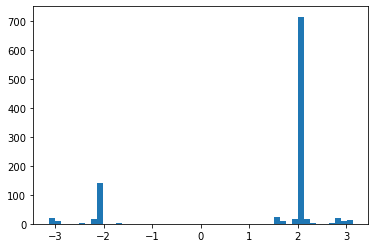

In [91]:
plt.hist(dataset.heading_list,bins=50)